In [1]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt

from zipfile import ZipFile

with ZipFile("archive.zip","r") as zip:
    zip.extractall()

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

batch_size = 32
img_size = (160,160)

Found 16854 files belonging to 33 classes.
Using 13484 files for training.
Found 16854 files belonging to 33 classes.
Using 3370 files for validation.


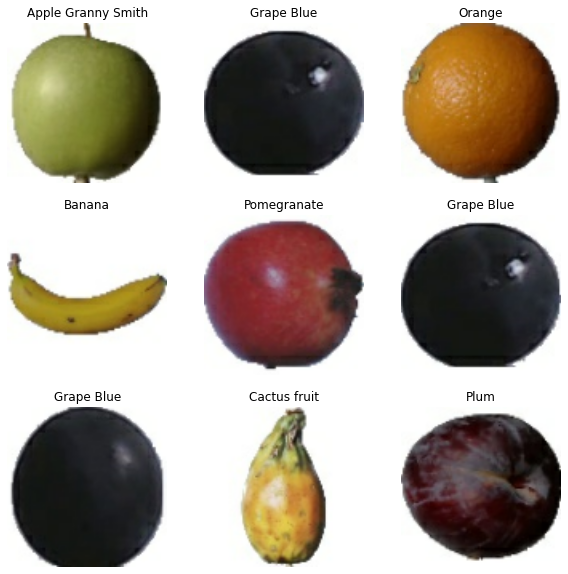

In [2]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.data.experimental import cardinality

train_ds = image_dataset_from_directory(
    "train/train",
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    shuffle = True,
    image_size = img_size,
    batch_size = batch_size,
)

val_ds = image_dataset_from_directory(
    "train/train",
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    shuffle = True,
    image_size = img_size,
    batch_size = batch_size,
)

class_names = train_ds.class_names

val_batches = cardinality(val_ds)
test_ds = val_ds.take(val_batches//5)
val_ds = val_ds.skip(val_batches//5)

plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

### Data Augmentation

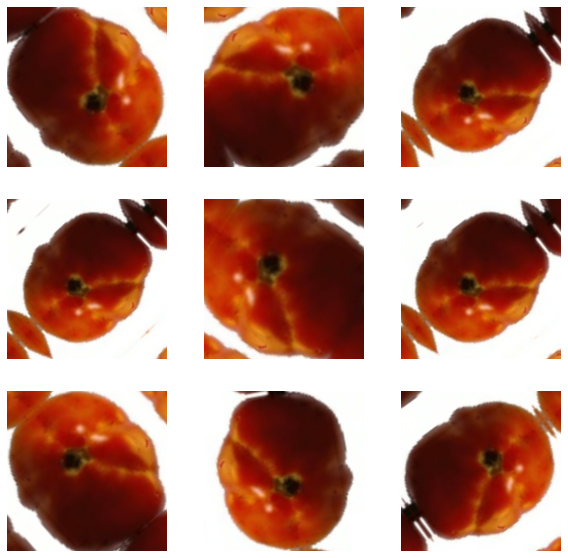

In [3]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomZoom, RandomRotation

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomZoom(0.2),
    RandomRotation(10),
])

plt.figure(figsize=(10,10))
for images,_ in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        augmented_images = data_augmentation(images)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
plt.show()

### Model: MobileNetV2 - Transfer Learning (Feature Extraction)

In [4]:
from tensorflow.keras import Input, Model
from tensorflow.keras.applications import mobilenet_v2, MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

rescale = mobilenet_v2.preprocess_input

img_shape = img_size+(3,)
base_model = MobileNetV2(input_shape=img_shape,include_top=False,weights="imagenet")
image_batch,label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)

base_model.trainable = False
base_model.summary()


class Transfer_MobileNetV2():
    def model(self,input):
        self.x = rescale(input)
        self.x = data_augmentation(self.x)
        self.x = base_model(self.x,training=False)
        self.x = GlobalAveragePooling2D()(self.x)
        self.x = Dropout(0.2,seed=42)(self.x)
        self.output = Dense(33,activation="softmax")(self.x)
        self.model = Model(input,self.output,name="Transfer_MobileNetV2")
        return self.model

TMBN2 = Transfer_MobileNetV2()
model = TMBN2.model(Input(shape=img_size+(3,)))
model.compile(Adam(),SparseCategoricalCrossentropy(),metrics=["accuracy"])
model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

Model: "Transfer_MobileNetV2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)     

### Train and evaluate the model

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

if __name__=="__main__":
    checkpoint = ModelCheckpoint("fruit.h5",save_weights_only=False,monitor="val_accuracy",save_best_only=True)
    model.fit(train_ds,epochs=2,validation_data=val_ds,callbacks=[checkpoint])
    best = load_model("fruit.h5")
    val_loss,val_acc = best.evaluate(val_ds)
    print("\nAccuracy: {:.2f} %".format(100*val_acc))
    print("Loss: {:.2f} %".format(100*val_loss))

Epoch 1/2
422/422 [==============================] - 24s 52ms/step - loss: 0.4299 - accuracy: 0.9053 - val_loss: 0.0741 - val_accuracy: 0.9989
Epoch 2/2


/home/maverick/.local/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


85/85 [==============================] - 4s 37ms/step - loss: 0.0296 - accuracy: 1.0000

Accuracy: 100.00 %
Loss: 2.96 %
